In [53]:
import os    
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [54]:
# imports
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn
from torch.autograd import Function
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import itertools
from tqdm.notebook import tqdm

In [55]:
batch_size = 128
data_path='/data/mnist'

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [56]:
# Define a transform
transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

train_full = datasets.MNIST(data_path, train=True, download=True, transform=transform)
test_full = datasets.MNIST(data_path, train=False, download=True, transform=transform)

In [57]:
class BinaryData(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = torch.from_numpy(x_data)
        self.y_data = torch.from_numpy(y_data).type(torch.LongTensor)
        self.len = len(self.y_data)

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.len

In [58]:
# Get indices of samples associated to filtered_classes
class_names = train_full.classes
filtered_classes = ['3 - three', '6 - six']
filtered_labels=[class_names.index(cl) for cl in filtered_classes]

train_data = {'x':[], 'y':[]}
for xdata, ydata in train_full:  
    if ydata in filtered_labels:
        train_data['x'].append(xdata.numpy())
        if filtered_labels.index(ydata) == 0:
            train_data['y'].append(0)
        else:
            train_data['y'].append(1)
        
test_data = {'x':[], 'y':[]}
for xdata, ydata in test_full:  
    if ydata in filtered_labels:
        test_data['x'].append(xdata.numpy())
        if filtered_labels.index(ydata) == 0:
            test_data['y'].append(0)
        else:
            test_data['y'].append(1)

In [59]:
train_dataset = BinaryData(np.array(train_data['x']), np.array(train_data['y']))
test_dataset = BinaryData(np.array(test_data['x']), np.array(test_data['y']))

In [60]:
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [61]:
# Network Architecture
num_inputs = 28*28
num_hidden = 100
num_outputs = 2

# Temporal Dynamics
num_steps = 25
beta = 0.95

In [62]:
# Define Network
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta)

    def forward(self, x):

        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        
        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        for step in range(num_steps):
            cur1 = self.fc1(x)
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)
        
# Load the network onto CUDA if available
net = Net().to(device)

In [63]:
# pass data into the network, sum the spikes over time
# and compare the neuron with the highest number of spikes
# with the target

def print_batch_accuracy(data, targets, train=False):
    output, _ = net(data.view(batch_size, -1))
    _, idx = output.sum(dim=0).max(1)
    acc = np.mean((targets == idx).detach().cpu().numpy())

    if train:
        print(f"Train set accuracy for a single minibatch: {acc*100:.2f}%")
    else:
        print(f"Test set accuracy for a single minibatch: {acc*100:.2f}%")

def train_printer():
    print(f"Epoch {epoch}, Iteration {iter_counter}")
    print(f"Train Set Loss: {loss_hist[counter]:.2f}")
    print(f"Test Set Loss: {test_loss_hist[counter]:.2f}")
    print_batch_accuracy(data, targets, train=True)
    print_batch_accuracy(test_data, test_targets, train=False)
    print("\n")

In [64]:
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))

data, targets = next(iter(train_loader))
data = data.to(device)
targets = targets.to(device)

spk_rec, mem_rec = net(data.view(batch_size, -1))
print(mem_rec.size())

torch.Size([25, 128, 2])


In [65]:
# initialize the total loss value
loss_val = torch.zeros((1), dtype=dtype, device=device)

# sum loss at every step
for step in range(num_steps):
    loss_val += loss(mem_rec[step], targets)

print(f"Training loss: {loss_val.item():.3f}")

Training loss: 16.309


In [66]:
print_batch_accuracy(data, targets, train=True)

Train set accuracy for a single minibatch: 65.62%


In [67]:
# clear previously stored gradients
optimizer.zero_grad()

# calculate the gradients
loss_val.backward()

# weight update
optimizer.step()

In [68]:
# calculate new network outputs using the same data
spk_rec, mem_rec = net(data.view(batch_size, -1))

# initialize the total loss value
loss_val = torch.zeros((1), dtype=dtype, device=device)

# sum loss at every step
for step in range(num_steps):
    loss_val += loss(mem_rec[step], targets)

print(f"Training loss: {loss_val.item():.3f}")
print_batch_accuracy(data, targets, train=True)

Training loss: 11.070
Train set accuracy for a single minibatch: 66.41%


In [69]:
num_epochs = 1
loss_hist = []
test_loss_hist = []
counter = 0

# Outer training loop
for epoch in range(num_epochs):
    iter_counter = 0
    train_batch = iter(train_loader)

    # Minibatch training loop
    for data, targets in train_batch:
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        net.train()
        spk_rec, mem_rec = net(data.view(batch_size, -1))

        # initialize the loss & sum over time
        loss_val = torch.zeros((1), dtype=dtype, device=device)
        for step in range(num_steps):
            loss_val += loss(mem_rec[step], targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Test set
        with torch.no_grad():
            net.eval()
            test_data, test_targets = next(iter(test_loader))
            test_data = test_data.to(device)
            test_targets = test_targets.to(device)

            # Test set forward pass
            test_spk, test_mem = net(test_data.view(batch_size, -1))

            # Test set loss
            test_loss = torch.zeros((1), dtype=dtype, device=device)
            for step in range(num_steps):
                test_loss += loss(test_mem[step], test_targets)
            test_loss_hist.append(test_loss.item())

            # Print train/test loss/accuracy
            if counter % 50 == 0:
                train_printer()
            counter += 1
            iter_counter +=1

Epoch 0, Iteration 0
Train Set Loss: 12.74
Test Set Loss: 8.77
Train set accuracy for a single minibatch: 68.75%
Test set accuracy for a single minibatch: 59.38%


Epoch 0, Iteration 50
Train Set Loss: 0.88
Test Set Loss: 1.14
Train set accuracy for a single minibatch: 100.00%
Test set accuracy for a single minibatch: 96.88%




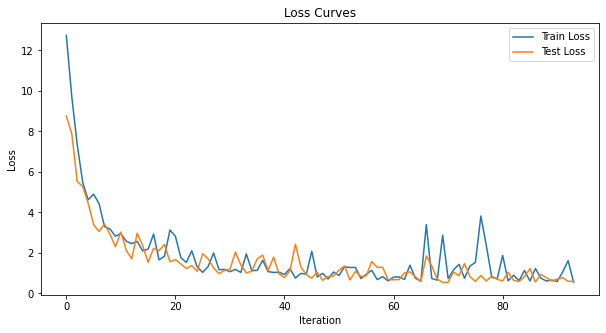

In [70]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(loss_hist)
plt.plot(test_loss_hist)
plt.title("Loss Curves")
plt.legend(["Train Loss", "Test Loss"])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

In [71]:
total = 0
correct = 0

# drop_last switched to False to keep all samples
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=False)

with torch.no_grad():
    net.eval()
    for data, targets in test_loader:
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        test_spk, _ = net(data.view(data.size(0), -1))

        # calculate total accuracy
        _, predicted = test_spk.sum(dim=0).max(1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

print(f"Total correctly classified test set images: {correct}/{total}")
print(f"Test Set Accuracy: {100 * correct / total:.2f}%")

Total correctly classified test set images: 1944/1968
Test Set Accuracy: 98.78%


# Quantum

In [72]:
import qiskit
from qiskit import transpile, assemble
import qiskit.visualization as vis

In [73]:
class QuantumCircuit:
    def __init__(self, n_qubits, backend, shots):
        self._circuit = qiskit.QuantumCircuit(n_qubits)
        
        all_qubits = [i for i in range(n_qubits)]
        self.theta = qiskit.circuit.Parameter('theta')
        
        self._circuit.h(all_qubits)
        self._circuit.barrier()
        self._circuit.ry(self.theta, all_qubits)
        
        self._circuit.measure_all()

        self.backend = backend
        self.shots = shots
    
    def run(self, thetas):
        t_qc = transpile(self._circuit,
                         self.backend)
        qobj = assemble(t_qc,
                        shots=self.shots,
                        parameter_binds = [{self.theta: theta} for theta in list(thetas)])
        job = self.backend.run(qobj)
        result = job.result().get_counts()
        
        counts = np.array(list(result.values()))
        states = np.array(list(result.keys())).astype(float)
#         states = 2*(states - 0.5)
        # Compute probabilities for each state
        probabilities = counts / self.shots
        # Get state expectation
        expectation = np.sum(states * probabilities)
        
        return np.array([expectation])
#         return probabilities

Expected value for rotation pi 0.55


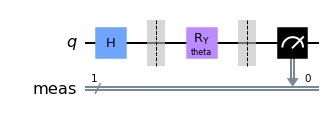

In [74]:
simulator = qiskit.Aer.get_backend('aer_simulator')

circuit = QuantumCircuit(1, simulator, 100)
print('Expected value for rotation pi {}'.format(circuit.run([np.pi])[0]))
circuit._circuit.draw('mpl')

In [75]:
class HybridFunction(Function):
    """ Hybrid quantum - classical function definition """
    
    @staticmethod
    def forward(ctx, inputs, quantum_circuit, shift):
        """ Forward pass computation """
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit
        expectation_z = ctx.quantum_circuit.run(inputs.tolist())
        result = torch.tensor([expectation_z])
        ctx.save_for_backward(inputs, result)

        return result
        
    @staticmethod
    def backward(ctx, grad_output):
        """ Backward pass computation """
        inputs, expectation_z = ctx.saved_tensors
        input_list = np.array(inputs.tolist())
        
        shift_right = input_list + np.ones(input_list.shape) * ctx.shift
        shift_left = input_list - np.ones(input_list.shape) * ctx.shift
                
        gradients = []
        for i in range(len(input_list)):
            expectation_right = ctx.quantum_circuit.run([shift_right[i]])
            expectation_left  = ctx.quantum_circuit.run([shift_left[i]])
            
            gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])
            gradients.append(gradient)
        gradients = np.array([gradients]).T
#         print(gradients)
        return torch.tensor([gradients]).float() * grad_output.float(), None, None

class Hybrid(nn.Module):
    """ Hybrid quantum - classical layer definition """
    
    def __init__(self, backend, shots, shift):
        super(Hybrid, self).__init__()
        self.quantum_circuit = QuantumCircuit(1, backend, shots)
        self.shift = shift
        
    def forward(self, input):
        return HybridFunction.apply(input, self.quantum_circuit, self.shift)

In [76]:
# Define Network
class Hybrid_qsnn(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta)
        self.fc2 = nn.Linear(num_hidden, 1)
        self.lif2 = snn.Leaky(beta=beta)
        self.hybrid = Hybrid(qiskit.Aer.get_backend('aer_simulator'), 100, np.pi / 2)

    def forward(self, x):

        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        
        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        for step in range(num_steps):
            cur1 = self.fc1(x)
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)
        
        summed_spk = torch.stack(spk2_rec, dim=0).sum(axis=0)
    
        x = [self.hybrid(summed_spk[i]) for i in range(len(summed_spk))]
        x1 = torch.cat(x)
        x0 = 1 - x1
        x=torch.cat((x0,x1), axis=1)
        return x

# Load the network onto CUDA if available
net = Hybrid_qsnn().to(device)

In [77]:
loss = nn.NLLLoss()
# loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))

data, targets = next(iter(train_loader))
data = data.to(device)
targets = targets.to(device)

pred = net(data.view(batch_size, -1))

print(pred.shape)

torch.Size([128, 2])


In [78]:
def print_batch_accuracy(data, targets, train=False):
    pred = net(data.view(batch_size, -1))
    _, idx =  pred.max(1)
    acc = np.mean((targets == idx).detach().cpu().numpy())

    if train:
        print(f"Train set accuracy for a single minibatch: {acc*100:.2f}%")
    else:
        print(f"Test set accuracy for a single minibatch: {acc*100:.2f}%")

def train_printer():
    print(f"Epoch {epoch}, Iteration {iter_counter}")
    print(f"Train Set Loss: {loss_hist[counter]:.2f}")
    print(f"Test Set Loss: {test_loss_hist[counter]:.2f}")
    print_batch_accuracy(data, targets, train=True)
    print_batch_accuracy(test_data, test_targets, train=False)
    print("\n")

In [79]:
num_epochs = 1
loss_hist = []
test_loss_hist = []
counter = 0

# Outer training loop
for epoch in tqdm(range(num_epochs)):
    iter_counter = 0
    train_batch = iter(train_loader)

    # Minibatch training loop
    for data, targets in tqdm(train_batch,leave=False):
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        net.train()
        preds = net(data.view(batch_size, -1))

        # initialize the loss & sum over time
        loss_val = torch.zeros((1), dtype=dtype, device=device)
        loss_val += loss(preds, targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Test set
        with torch.no_grad():
            net.eval()
            test_data, test_targets = next(iter(test_loader))
            test_data = test_data.to(device)
            test_targets = test_targets.to(device)
            
            # Test set forward pass
            test_preds = net(test_data.view(batch_size, -1))

            # Test set loss
            test_loss = torch.zeros((1), dtype=dtype, device=device)
            test_loss += loss(test_preds, targets)
            test_loss_hist.append(test_loss.item())

            # Print train/test loss/accuracy
            if counter % 5 == 0:
                train_printer()
            counter += 1
            iter_counter +=1

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

<ipython-input-75-dd8171740cb6>:31: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  gradients = np.array([gradients]).T


Epoch 0, Iteration 0
Train Set Loss: -0.48
Test Set Loss: -0.52
Train set accuracy for a single minibatch: 56.25%
Test set accuracy for a single minibatch: 61.72%


Epoch 0, Iteration 5
Train Set Loss: -0.61
Test Set Loss: -0.53
Train set accuracy for a single minibatch: 59.38%
Test set accuracy for a single minibatch: 54.69%


Epoch 0, Iteration 10
Train Set Loss: -0.67
Test Set Loss: -0.50
Train set accuracy for a single minibatch: 63.28%
Test set accuracy for a single minibatch: 71.09%


Epoch 0, Iteration 15
Train Set Loss: -0.73
Test Set Loss: -0.53
Train set accuracy for a single minibatch: 80.47%
Test set accuracy for a single minibatch: 80.47%


Epoch 0, Iteration 20
Train Set Loss: -0.79
Test Set Loss: -0.47
Train set accuracy for a single minibatch: 85.16%
Test set accuracy for a single minibatch: 85.94%


Epoch 0, Iteration 25
Train Set Loss: -0.82
Test Set Loss: -0.43
Train set accuracy for a single minibatch: 93.75%
Test set accuracy for a single minibatch: 89.84%


Epoch 